In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_24140/1763670448.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# Cmport dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# Convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# Transform species to number
labels = torch.zeros(len(data), dtype=torch.long)

# Labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

# Separate the data into DataLoaders

In [3]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_data_set = torch.utils.data.TensorDataset(train_data, train_labels)
test_data_set = torch.utils.data.TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
batch_size = 16
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data_set, batch_size=test_data_set.tensors[0].shape[0])

# Create the model and a training regimen

In [11]:
class the_model_class(nn.Module):
  def __init__(self, dropout_rate):
    super().__init__()

    # Layers
    self.input = nn.Linear(in_features=4, out_features=12)
    self.hidden = nn.Linear(in_features=12, out_features=12)
    self.output = nn.Linear(in_features=12, out_features=3)

    # Parameters
    self.dropout_rate = dropout_rate

  # Forward pass
  def forward(self, x):

    # Pass the data through the input layer
    x = F.relu(self.input(x))

    # Dropout after input layer
    x = F.dropout(input=x, p=self.dropout_rate, training=self.training)

    # Pass the data through the hidden layer
    x = F.relu(self.hidden(x))

    # Dropout after hidden layer
    x = F.dropout(input=x, p=self.dropout_rate, training=self.training)

    # Output layer
    x = self.output(x)

    # No dropout here!!
    return x


In [12]:
# Test the model
temp_net = the_model_class(dropout_rate=0.25)

# Run some random data through
temp_data = torch.randn((10, 4)) # 10 data points, 04 features
y_hat = temp_net(temp_data)
print(y_hat)

tensor([[-0.0754,  0.3514,  0.1882],
        [-0.0895,  0.4689,  0.2085],
        [-0.1056,  0.3486,  0.1577],
        [ 0.0500,  0.2807,  0.0829],
        [ 0.0358,  0.2034,  0.0761],
        [-0.1409,  0.3772,  0.2075],
        [ 0.1551,  0.0745,  0.1105],
        [-0.0486, -0.0207,  0.0668],
        [ 0.0410,  0.3381,  0.0585],
        [-0.0907,  0.3100,  0.1661]], grad_fn=<AddmmBackward0>)


# Functions to create and train the net

In [13]:
def create_a_new_model(dropout_rate):

  # Grab an instance of the model class
  ANN_iris = the_model_class(dropout_rate=dropout_rate)

  # Loss function
  loss_func = nn.CrossEntropyLoss()

  # Optimizer
  optimizer = torch.optim.SGD(params=ANN_iris.parameters(), lr=0.005)

  return ANN_iris, loss_func, optimizer

In [14]:
# Training parameter
num_epochs = 500

# Note: this time, the model, lossfun, and optimizer are inputs into the function!
def train_the_model(ANN_iris, loss_func, optimizer):

  # Initialize accuracies as empties (not storing losses here)
  train_acc = []
  test_acc = []

  # Loop over epochs
  for epoch_i in range(num_epochs):

    # Switch training mode on (is this the right place for this code??)
    ANN_iris.train()

    # Loop over training data batches
    batch_acc = []
    for X, y in train_loader:

      # Forward pass and loss
      y_hat = ANN_iris(X)
      loss = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy
    train_acc.append(np.mean(batch_acc))

    # Test accuracy
    # Switch training off, not implement any dropout
    ANN_iris.eval()
    # Extract x,y from test dataloader
    X, y = next(iter(test_loader))
    y_hat = ANN_iris(X)
    test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())
  
  # Function output
  return train_acc, test_acc

# Now for the real work! ;)

In [16]:
# Create a model
dropout_rate = 0.0
ANN_iris, loss_func, optimizer = create_a_new_model(dropout_rate=dropout_rate)

# Train the model (note the inputs!)
train_acc, test_acc = train_the_model(ANN_iris=ANN_iris, loss_func=loss_func, optimizer=optimizer)

In [17]:
# Create a 1D smoothing filter
def smooth(x, k = 5):
  return np.convolve(a=x, v=np.ones(k) / k, mode='same')

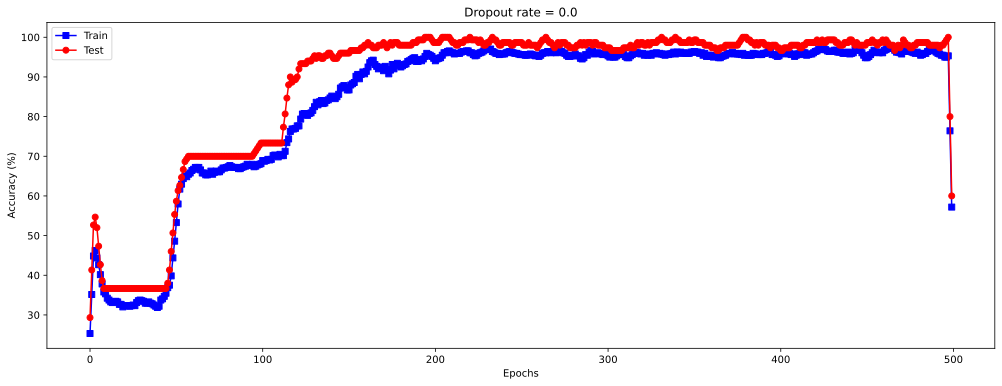

In [18]:
# Plot the results
fig = plt.figure(figsize=(17, 6))

plt.plot(smooth(train_acc), 'bs-')
plt.plot(smooth(test_acc), 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train', 'Test'])
plt.title(f'Dropout rate = {dropout_rate}')

plt.show()

In [19]:
# Run an experiment (note: takes ~3.5 mins)
dropout_rates = np.arange(10) / 10 # 0 -> 1
results = np.zeros(shape=(len(dropout_rates), 2))

for dropout_rate_i in range(len(dropout_rates)):
  
  # Create and train the model
  ANN_iris, loss_func, optimizer = create_a_new_model(dropout_rate=dropout_rates[dropout_rate_i])
  train_acc, test_acc = train_the_model(ANN_iris=ANN_iris, loss_func=loss_func, optimizer=optimizer)

  # Store accuracies from last 50 epochs
  results[dropout_rate_i, 0] = np.mean(train_acc[-50:])
  results[dropout_rate_i, 1] = np.mean(test_acc[-50:])

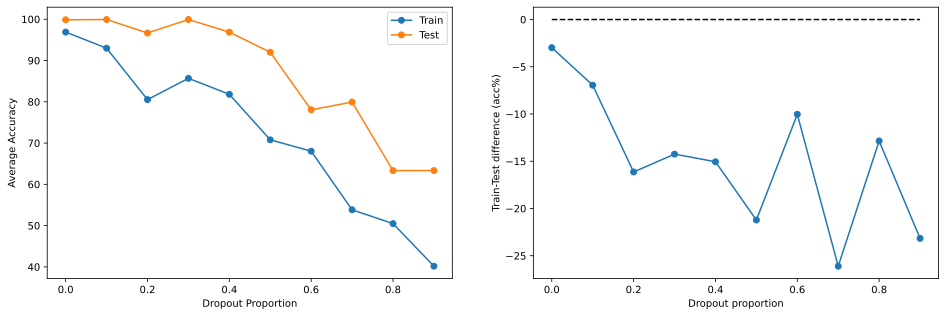

In [20]:
# Plot the experiment results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

ax[0].plot(dropout_rates, results, 'o-')
ax[0].set_xlabel('Dropout Proportion')
ax[0].set_ylabel('Average Accuracy')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropout_rates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, 0.9], [0, 0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-Test difference (acc%)')

plt.show()

# Additional explorations
1) Remove the ReLU nonlinearity from the network. Does that change the effect of dropout proportion on performance?

2) I mentioned that dropout doesn't necessarily improve performance for shallow models. What happens if you increase 
   the complexity of this model, for example by adding several additional (and wider) hidden layers?